# Home task 

Find the public dataset and apply collaborative filtering recommendation



LINK: https://www.kaggle.com/datasets/rishitjavia/netflix-movie-rating-dataset/data

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv("Netflix_Dataset_Rating.csv")

Limiting to 10 000 movies and shuffeling df

In [59]:

data = data.sample(frac=1).reset_index(drop=True)
data = data.iloc[:10000]
data

,User_ID,Rating,Movie_ID
0,321679,3,1659
1,776492,5,1110
2,1732397,3,2209
3,796122,5,257
4,1834227,5,191
...,...,...,...
9995,2224112,2,3526
9996,2510664,4,4266
9997,844855,4,1542
9998,1618693,5,3538


In [60]:
def J(Y, R, X, Theta, lambd):
    '''
    params: 1d vector  of X and Theta
    :return expression for cost function
    '''
    assert (X.shape[1] == Theta.shape[0])
    h = X @ Theta

    try:
        assert (h.shape == Y.shape)
    except:
        print('h.shape {} !=Y.shape {}'.format(h.shape, Y.shape))

    J = 1 / 2 * np.sum(((h - Y) * R) ** 2) + lambd / 2 * np.sum(X ** 2) + lambd / 2 * np.sum(Theta ** 2)
    try:
        assert (len(J.shape) == 0)
    except:
        print('J is not raw number. J.shape = ', J.shape)

    return J


def J_derivative(Y, R, X, Theta, num_movies, num_users, num_features, lambd):
    cost_matr = (X @ Theta - Y) * R  # n_movies * n_users

    X_grad = cost_matr @ Theta.T
    Theta_grad = (cost_matr.T @ X).T

    try:
        assert (X_grad.shape == X.shape)
        assert (Theta_grad.shape == Theta.shape)
    except:
        print('Check gradient calculus')

    # Regularization part :
    X_grad += lambd * X
    Theta_grad += lambd * Theta

    return X_grad, Theta_grad


def fit(Y, R, num_features=10, alpha=0.0001, lambd=.01, eps=.1, max_iter=1000, step=100, verbose=0):
    num_movies, num_users = Y.shape

    if verbose:
        print('Running gradient descent with alpha= {}, lambda= {}, eps= {}, max_iter= {}'.format(
            alpha, lambd, eps, max_iter))

    #     X= params[:num_movies*num_features].reshape(num_movies,num_features)
    #     Theta = params[num_movies*num_features:].reshape(num_features,num_users)

    np.random.seed(2019)
    X = np.random.randn(num_movies, num_features)
    Theta = np.random.randn(num_features, num_users)

    J_hist = [-1]  # used for keeping J values. Init with -1 to avoid 0 at first iter
    continue_iter = True  # flag to continue next iter (grad desc step)
    iter_number = 0  # used for limit by max_iter

    try:
        while continue_iter:
            # Do step of gradient descent
            X_grad, Theta_grad = J_derivative(Y, R, X, Theta, num_movies, num_users, num_features, lambd)
            X = X - alpha * X_grad
            Theta = Theta - alpha * Theta_grad

            # keep history of J values
            J_hist.append(J(Y, R, X, Theta, lambd))
            # check criteria of exit (finish grad desc)
            if iter_number > max_iter:  # if limit succeeded
                continue_iter = False
                print('iter_number> max_iter')
            elif np.abs(J_hist[iter_number - 1] - J_hist[iter_number]) < eps:  # if accuracy is succeeded
                continue_iter = False
                print('J_hist[iter_number]={}'.format(J_hist[iter_number]))
            iter_number += 1

            if verbose and iter_number % step == 0:
                print('{}: {}'.format(iter_number, J_hist[iter_number - 1]))
        return X, Theta, J_hist
    except Exception as e:
        print('Training is interrupted due to error:', e)
        return X, Theta, J_hist


def draw_cost_changes(J_hist):
    J_hist=J_hist[1:]
    plt.figure()
    plt.scatter(np.arange(0,len(J_hist)),J_hist,s=20,marker='.',c='b')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.show()


def normalize_Y(Y,R, n_0):
    Ymean = np.zeros((n_0, 1))
    Ynorm = np.zeros(Y.shape)
    for i in range(n_0):
        idx = R[i,:] == 1
        Ymean[i] = Y[i, idx].mean()
        Ynorm[i, idx]= Y[i, idx] - Ymean[i]
    return Ymean, Ynorm



def fit_collaborative_filtering(Y, R, n_features=20, max_iter=50000, verbose=1, return_J_hist= False):
    '''
        Y: df of provided values
        R: df of 0 and 1 - marked values as provided (e.g. R is 1 for elements of Y that are not 0)
    '''

    scale = Y.max() - Y.min()
    Y_scaled = Y / scale * 10
    n_0 = Y_scaled.shape[0]
    Ymean, Ynorm = normalize_Y(Y_scaled.values, R.values, n_0)
    X, Theta, J_hist = fit(Ynorm, R.values, num_features=n_features, alpha=0.0005, lambd=1, max_iter=max_iter,
                           eps=.01, step=50, verbose=verbose)
    # if verbose:
    #     draw_cost_changes(J_hist)

    pred = X @ Theta
    pred_rescaled = (pred + Ymean) * scale.values / 10

    df_results_pivot= pd.DataFrame(pred_rescaled , index= Y.index, columns = Y.columns)

    if return_J_hist:
        return df_results_pivot, J_hist
    else:
        return df_results_pivot

# ========== Let's try to cover  more steps here:

def convert_to_matrix(df, index, columns, values):
    '''
        e.g. values='average_msv', index='phrase', columns='locode'
    '''
    df_target=df.pivot_table(index=index, columns=columns, values=values, aggfunc=np.max, dropna= False)
    return df_target

def fit_target(df_target, index, columns, values, n_features=20, max_iter=5000, verbose=1):
    Y= df_target.fillna(0) # not sure it is necessary
    R= df_target.applymap(lambda x: 0 if np.isnan(x) else 1)

    df_results_pivot, J_hist = fit_collaborative_filtering(Y, R, n_features=n_features, max_iter=max_iter, verbose=verbose, return_J_hist= True)

    df_results_pivot_temp= pd.DataFrame(df_results_pivot.to_records())
    df_results = pd.melt(df_results_pivot_temp,
                id_vars=index, # 'iid',
                value_vars=list(df_results_pivot_temp.columns[1:]),
                var_name= columns,# 'uid',
                value_name= '{}_pred'.format(values)) # 'rating_pred')
    return df_results,  J_hist




def round_to_existing(val, existing_unique_values):
    return existing_unique_values[np.argmin(np.abs(existing_unique_values-val))]


def fill_missed(df_input, df_missed= None, compute_average_for_blank_columns= False, n_features=20, max_iter=5000, verbose=1, return_J_hist= False):
    '''
    :param df_input: df with three columns - index, columns, values- all values are provided
    :param df_missed- df with 2 or 3 columns - but first two are index, columns
    :return:  df_predict - that contains all possible combinations
    '''
    columns,values,index= list(df_input)
    print ('index: {}, columns: {}, values: {}'.format(index, columns, values))

    if compute_average_for_blank_columns:
        df_input_atleast= df_input
    else:
        df_input_atleast = df_input.dropna()

    df_target = convert_to_matrix(df_input_atleast, index=index, columns=columns, values=values)
    df_pred, J_hist = fit_target(df_target, index, columns, values, n_features=n_features, max_iter=max_iter, verbose=verbose)

    existing_unique_values = np.array(sorted(df_input[values].unique()))
    df_pred['{}_pred_round'.format(values)]= df_pred['{}_pred'.format(values)].apply(lambda x: round_to_existing(x,existing_unique_values))
    df_pred[index]=df_pred[index].astype(df_input.dtypes[index])
    df_pred[columns] = df_pred[columns].astype(df_input.dtypes[columns])
    df_pred= df_pred.merge(df_input, how='outer', on = ([index, columns]))
    df_pred= df_pred[[index,columns, values, '{}_pred_round'.format(values), '{}_pred'.format(values)]]

    if df_missed is None:
        df_out= df_pred
    else:
        df_out = df_missed.merge(df_pred, how= 'left', on= ([index, columns]))

    if return_J_hist:
        return df_out, J_hist
    else:
        return df_out


Getting pred df and j_hist

In [61]:
df_pred, J_hist = fill_missed(data, compute_average_for_blank_columns= False, n_features=20, max_iter=7500, return_J_hist= 1)

index: Movie_ID, columns: User_ID, values: Rating


C:\Users\admin\AppData\Local\Temp\ipykernel_4380\1703354264.py:137: FutureWarning: The provided callable <function max at 0x000001D844EB16C0> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_target=df.pivot_table(index=index, columns=columns, values=values, aggfunc=np.max, dropna= False)
C:\Users\admin\AppData\Local\Temp\ipykernel_4380\1703354264.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  R= df_target.applymap(lambda x: 0 if np.isnan(x) else 1)


Running gradient descent with alpha= 0.0005, lambda= 1, eps= 0.01, max_iter= 7500
50: 111070.8593195852
100: 97255.14593902978
150: 90635.59656340882
200: 85594.24540308594
250: 81161.94549532433
300: 77081.23733786297
350: 73259.75348055732
400: 69655.057450655
450: 66243.08018814771
500: 63007.65899242709
550: 59936.5252272058
600: 57019.572493827254
650: 54248.03008957868
700: 51614.0323586724
750: 49110.37683612693
800: 46730.37979375326
850: 44467.78546006983
900: 42316.706250995805
950: 40271.581463902454
1000: 38327.147209297415
1050: 36478.41335354848
1100: 34720.64497492857
1150: 33049.34681967821
1200: 31460.24980039256
1250: 29949.29890496951
1300: 28512.642094782346
1350: 27146.61992028017
1400: 25847.755691762108
1450: 24612.746119824307
1500: 23438.45238855096
1550: 22321.891650606103
1600: 21260.228943570415
1650: 20250.769527366938
1700: 19290.951638337523
1750: 18378.339649782854
1800: 17510.61762347401
1850: 16685.58323266027
1900: 15901.14203466089
1950: 15155.302070

Perdicted df

In [62]:
df_pred

,Movie_ID,User_ID,Rating,Rating_pred_round,Rating_pred
0,3,134,NaN,5,5.001126
1,8,134,NaN,5,4.997607
2,16,134,NaN,5,5.000326
3,17,134,NaN,5,4.998942
4,18,134,NaN,5,4.999589
...,...,...,...,...,...
11403855,4488,2649120,NaN,3,3.000567
11403856,4490,2649120,NaN,3,3.000538
11403857,4492,2649120,NaN,3,2.764662
11403858,4493,2649120,NaN,3,2.998656


Clearing df

In [63]:
df_pred[df_pred['Rating'].notna()]

,Movie_ID,User_ID,Rating,Rating_pred_round,Rating_pred
491,1810,134,5.0,5,4.981815
1444,886,592,5.0,5,4.980823
3004,2290,602,4.0,4,4.000011
3967,1370,981,3.0,3,3.000000
4957,607,998,4.0,4,3.991639
...,...,...,...,...,...
11398451,2140,2648609,1.0,1,0.951866
11399620,2009,2648869,3.0,3,3.000001
11401339,3962,2648873,4.0,4,3.999990
11402147,2521,2648885,3.0,3,2.910660


Draw cost

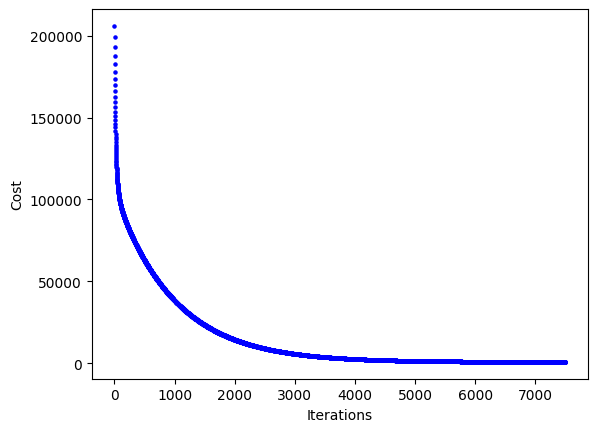

In [64]:
draw_cost_changes(J_hist)